# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Homewor: Inference in NN 

**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors:** Pavlos Protopapas, Mark Glickman, Chris Tanner<br/>

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
#RUN THIS CELL
import os
import pathlib
working_dir = pathlib.Path().absolute()
os.chdir(working_dir)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import StandardScaler

sns.set()

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, History 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import cross_val_score,  KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from tensorflow.keras import optimizers

from functools import partial

np.random.seed(0)


%matplotlib notebook
%matplotlib inline

<div class="theme"> Overview </div> 

In this homework, we will investigate methods for uncertainty quantification in deep neural networks. These are alternatives to the robust MCMC that doesn't scale to large models.

<div class='exercise'><b> Question 1: Dropout as a Bayesian Approximation [10 pts] (Gal & Ghahramani 2015, https://arxiv.org/abs/1506.02142)</b></div>  

For this question, we will be generate a synthetic dataset in order to be able to test different uncertainty regimes, we will train the model with a gap in the data. 

**1.1** [1 pt] Generate a synthetic two dimensional dataset using the function y = 0.1 * x^3 plus random noise (0, 0.25). Generate a training set of 200 points with no data in the range x=[-1,1]. Generate a test set of 80 data points with values uniformly distributed in the whole domain. Plot the two data sets.

**1.2** [2 pts] Create a fully connected neural network with 3 layers of 20 nodes each. Include dropout (using the Dropout class provided) before the last layer. 

**1.3** [2 pts] Train the network with dropout of 0.1, do inference for all the test points 10 times in training mode. From the outputs, find the model mean and standard variation. Repeat with dropoout of 0.2.

**1.4** [1 pt] Make a plot of the data, the model, and the uncertainty. Show the model mean and color the region of tow standard deviations.

**1.5** [2 pts] Turn dropout off (set it to 0) and train 50 models bootstrapping the training data. Doing statistics on the outputs, make a plot of the data, the model, and the uncertainty. Show the model mean and color the region two standard deviations away, as in **1.3**

**1.6** [2 pts] Compare both methods and discuss the pros and cons of each.



## Answers

**1.1** [1 pt] Generate a synthetic two dimensional dataset using the function y = 0.1 * x^3 plus random noise (0, 0.25). Generate a training set of 200 points with no data in the range x=[-1,1]. Generate a test set of 80 data points with values uniformly distributed in the whole domain. Plot the two data sets.


In [4]:
def build_dataset(N, noise_std=0.25, is_test=True):
    dataset = np.zeros((N,2))
    x = np.random.uniform(-4,4,10000)
    if is_test is False: # Omit data from -1 to 1
        filtered_xs = np.argwhere((x < -1) | (x > 1))
        x = np.copy(x[filtered_xs])
    dataset[:,0] = x[:N].flatten()
    dataset[:,1] = 0.1 * dataset[:,0]**3 + np.random.normal(0,noise_std)
    return dataset
    # your code here


In [5]:
# your code here
train_ds = build_dataset(200,is_test=False)
test_ds = build_dataset(80, is_test=True)

[Text(0, 0.5, 'y'), Text(0.5, 0, 'x'), Text(0.5, 1.0, 'Test Data')]

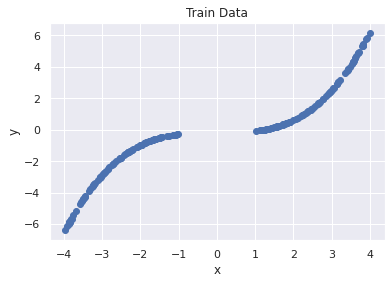

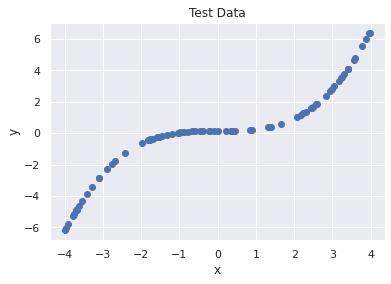

In [6]:
# your code here
fig, ax = plt.subplots()
ax.scatter(train_ds[:,0],train_ds[:,1])

ax.set(xlabel='x', ylabel='y',
       title='Train Data')

fig, ax = plt.subplots()
ax.scatter(test_ds[:,0],test_ds[:,1])

ax.set(xlabel='x', ylabel='y',
       title='Test Data')

**1.2** [2 pts] Create a fully connected neural network with 3 layers of 20 nodes each. Include dropout (using the Dropout class provided) before the last layer.


In [7]:
# https://github.com/keras-team/keras/issues/9412

class Dropout(layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=None, noise_shape=None, seed=None, **kwargs):
        super(Dropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

In [8]:
# create model 
model = Sequential()
model.add(Dense(20, input_dim=1, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [9]:
# Fit the model
model.fit(train_ds[:,0],train_ds[:,1], epochs=100)

Train on 200 samples
Epoch 1/100
200/200 [==============================] - 1s 4ms/sample - loss: 8.7154
Epoch 2/100
200/200 [==============================] - 0s 94us/sample - loss: 8.1444
Epoch 3/100
200/200 [==============================] - 0s 96us/sample - loss: 7.5087
Epoch 4/100
200/200 [==============================] - 0s 94us/sample - loss: 6.8073
Epoch 5/100
200/200 [==============================] - 0s 92us/sample - loss: 6.0387
Epoch 6/100
200/200 [==============================] - 0s 94us/sample - loss: 5.3981
Epoch 7/100
200/200 [==============================] - 0s 96us/sample - loss: 4.6151
Epoch 8/100
200/200 [==============================] - 0s 99us/sample - loss: 4.0064
Epoch 9/100
200/200 [==============================] - 0s 99us/sample - loss: 3.1571
Epoch 10/100
200/200 [==============================] - 0s 607us/sample - loss: 2.5838
Epoch 11/100
200/200 [==============================] - 0s 96us/sample - loss: 2.1965
Epoch 12/100
200/200 [====================

Epoch 96/100
200/200 [==============================] - 0s 94us/sample - loss: 0.4494
Epoch 97/100
200/200 [==============================] - 0s 95us/sample - loss: 0.5350
Epoch 98/100
200/200 [==============================] - 0s 102us/sample - loss: 0.3648
Epoch 99/100
200/200 [==============================] - 0s 99us/sample - loss: 0.3859
Epoch 100/100
200/200 [==============================] - 0s 97us/sample - loss: 0.3327


In [10]:
# evaluate the training and testing performance of your model 
from sklearn.metrics import mean_squared_error
print("MSE Of Train w/ Dropout Rate 0.2",mean_squared_error(train_ds[:,1], model.predict(train_ds[:,0])) )
print("MSE Of Test w/ Dropout Rate 0.2",mean_squared_error(test_ds[:,1], model.predict(test_ds[:,0])) )


MSE Of Train w/ Dropout Rate 0.2 0.15442713795879578
MSE Of Test w/ Dropout Rate 0.2 0.2083210852404111


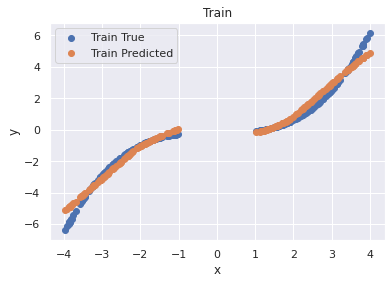

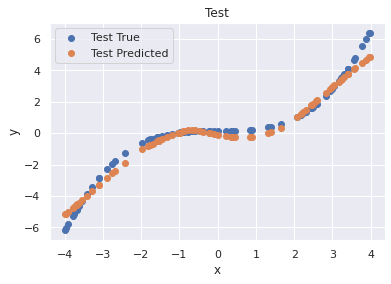

In [11]:
# plot
fig, ax = plt.subplots()
ax.scatter(train_ds[:, 0], train_ds[:, 1], label="Train True")
ax.scatter(train_ds[:, 0], model.predict(train_ds[:,0]), label="Train Predicted")


ax.set(xlabel='x', ylabel='y',
       title='Train')
ax.legend()

fig, ax = plt.subplots()
ax.scatter(test_ds[:, 0], test_ds[:, 1], label="Test True")
ax.scatter(test_ds[:, 0], model.predict(test_ds[:,0]), label="Test Predicted")


ax.set(xlabel='x', ylabel='y',
       title='Test')
ax.legend()



**1.3** [2 pts] Train the network with dropout of 0.1, do inference for all the test points 10 times in training mode. From the outputs, find the model mean and standard variation. Repeat with dropoout of 0.2.


In [12]:
# your code here
model = Sequential()
model.add(Dense(20, input_dim=1, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(rate=0.1, training=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_ds[:,0], train_ds[:,1],  epochs=100, verbose=0)


In [13]:
from tqdm import tqdm
predictions = np.zeros((test_ds.shape[0],10))

for j in range(10):
    for i in tqdm(range(test_ds.shape[0])):
        predictions[i,j] =model.predict(test_ds[i,0].reshape(1,1))

100%|██████████| 80/80 [00:03<00:00, 25.77it/s]


In [14]:
# your code here
means_10 = np.zeros((test_ds.shape[0]))
stds_10 = np.zeros((test_ds.shape[0]))
for i in tqdm(range(test_ds.shape[0])):
    means_10[i] = np.mean(predictions[i,:])
    stds_10[i] = np.std(predictions[i,:])


100%|██████████| 80/80 [00:00<00:00, 23225.88it/s]


In [15]:
# your code here
model = Sequential()
model.add(Dense(20, input_dim=1, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(rate=0.2, training=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_ds[:,0], train_ds[:,1], epochs=100, verbose=0)



In [16]:
from tqdm import tqdm
predictions = np.zeros((test_ds.shape[0],10))
for j in range(10):
    for i in tqdm(range(test_ds.shape[0])):
        predictions[i,j] =model.predict(test_ds[i,0].reshape(1,1))
# your code here
means_20 = np.zeros((test_ds.shape[0]))
stds_20 = np.zeros((test_ds.shape[0]))
for i in tqdm(range(test_ds.shape[0])):
    means_20[i] = np.mean(predictions[i,:])
    stds_20[i] = np.std(predictions[i,:])


100%|██████████| 80/80 [00:00<00:00, 14080.75it/s]


**1.4** [1 pt] Make a plot of the data, the model, and the uncertainty. Show the model mean and color the region of tow standard deviations.


[Text(0, 0.5, 'y'), Text(0.5, 0, 'x'), Text(0.5, 1.0, 'Dropout Rate=0.2')]

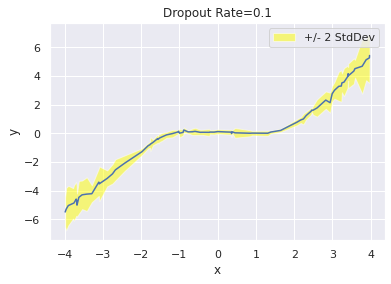

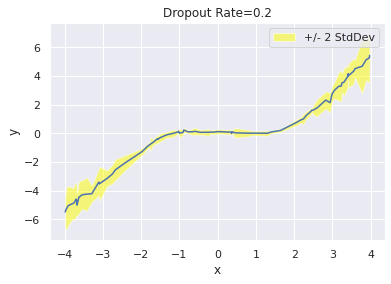

In [17]:
# plot 
# your code here
fig, ax = plt.subplots()
df_10 = pd.DataFrame()
df_10['x'] = test_ds[:,0]
df_10['mean'] = means_10
df_10['std'] = stds_10
df_10 = df_10.sort_values(by='x', ascending=True)
ax.plot(df_10['x'], df_10['mean'])
ax.fill_between(df_10['x'], df_10['mean'] - 2*df_10['std'],df_10['mean'] + 2*df_10['std'],facecolor='yellow', alpha=0.5, label="+/- 2 StdDev")
ax.legend()

ax.set(xlabel='x', ylabel='y',
       title='Dropout Rate=0.1')

fig, ax = plt.subplots()
df_20 = pd.DataFrame()
df_20['x'] = test_ds[:,0]
df_20['mean'] = means_20
df_20['std'] = stds_20
df_20 = df_10.sort_values(by='x', ascending=True)
ax.plot(df_20['x'], df_20['mean'])
ax.fill_between(df_20['x'], df_20['mean'] - 2*df_20['std'],df_20['mean'] + 2*df_20['std'],facecolor='yellow', alpha=0.5, label="+/- 2 StdDev")
ax.legend()

ax.set(xlabel='x', ylabel='y',
       title='Dropout Rate=0.2')


**1.5** [2 pts] Turn dropout off (set it to 0) and train 50 models bootstrapping the training data. Doing statistics on the outputs, make a plot of the data, the model, and the uncertainty. Show the model mean and color the region tow standard deviations away, as in **1.3**


In [18]:
# define model 
model = Sequential()
model.add(Dense(20, input_dim=1, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(rate=0.0, training=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [19]:
# you may need this 
# from https://github.com/keras-team/keras/issues/341#issuecomment-438347068

def reset_weights(model):
    for layer in model.layers: 
        if isinstance(layer, tf.keras.Model):
            reset_weights(layer)
            continue
    for k, initializer in layer.__dict__.items():
        if "initializer" not in k:
            continue
        # find the corresponding variable
        var = getattr(layer, k.replace("_initializer", ""))
        var.assign(initializer(var.shape, var.dtype))

In [20]:
# Bootstrap and run model 
from tqdm import tqdm
predictions = np.zeros((test_ds.shape[0],50))
for j in tqdm(range(50)):
    idx = np.random.randint(0,200,150)
    reset_weights(model)
    model.fit(train_ds[idx, 0],train_ds[idx, 1],  epochs=100, verbose=0)
    for i in range(test_ds.shape[0]):
        predictions[i,j] =model.predict(test_ds[i,0].reshape(1,1))




100%|██████████| 50/50 [03:25<00:00,  4.11s/it]


In [21]:
np.std(predictions[20,:])

0.20748989620743563

In [22]:
# your code here 
means_50 = np.zeros((test_ds.shape[0]))
stds_50 = np.zeros((test_ds.shape[0]))
for i in tqdm(range(test_ds.shape[0])):
    means_50[i] = np.mean(predictions[i,:])
    stds_50[i] = np.std(predictions[i,:])

100%|██████████| 80/80 [00:00<00:00, 12520.31it/s]


In [23]:
stds_50

array([0.44291969, 0.43860732, 0.57501728, 0.73837822, 0.44779957,
       0.4371028 , 0.23744156, 0.21674566, 0.12012807, 0.65203676,
       0.20248239, 0.17573643, 0.55803584, 0.40596425, 0.45059173,
       0.62680291, 0.24668354, 0.3711102 , 0.43825824, 0.48887255,
       0.2074899 , 0.35003946, 0.44741222, 0.48285884, 0.2418106 ,
       0.45084168, 0.2225568 , 0.47388226, 0.36454382, 0.44859574,
       0.18042942, 0.38031957, 0.36601961, 0.40888094, 0.48665582,
       0.3375882 , 0.2232399 , 0.31920133, 0.54502818, 0.36381944,
       0.19741524, 0.69456286, 0.44752121, 0.30465295, 0.43207105,
       0.19423015, 0.18685157, 0.44235964, 0.3728338 , 0.44904103,
       0.43329261, 0.45098377, 0.45129653, 0.21474436, 0.34694858,
       0.3854436 , 0.4358876 , 0.33309735, 0.16081833, 0.64427125,
       0.48863229, 0.31473132, 0.3974407 , 0.44638416, 0.44577475,
       0.4467903 , 0.42624856, 0.73631496, 0.34803009, 0.3292043 ,
       0.28287265, 0.44463673, 0.42459866, 0.43885424, 0.19847

[Text(0, 0.5, 'y'),
 Text(0.5, 0, 'x'),
 Text(0.5, 1.0, '50 Models, Bootstrapped')]

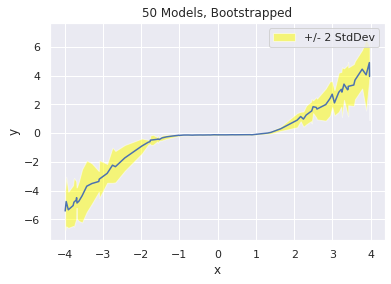

In [24]:
# plot 

fig, ax = plt.subplots()
df_50 = pd.DataFrame()
df_50['x'] = test_ds[:,0]
df_50['mean'] = means_20
df_50['std'] = stds_20
df_50 = df_50.sort_values(by='x', ascending=True)
ax.plot(df_50['x'], df_50['mean'])
ax.fill_between(df_50['x'], df_50['mean'] - 2*df_50['std'],df_50['mean'] + 2*df_50['std'],facecolor='yellow', alpha=0.5, label="+/- 2 StdDev")
ax.legend()

ax.set(xlabel='x', ylabel='y',
       title='50 Models, Bootstrapped')


**1.6** [2 pts] Compare both methods and discuss the pros and cons of each.


Dropout is a beneficial practice as it reduces overfitting by omitting a given percentage of weights at each step. However, while reducing overfitting, it may result in Underfitting in situations where there is a complex relationship that relies on nearly all of the weights in a given level to convey. It is however, very computationally inexpensive and can easily be tuned on a per-layer basis by simply changing the dropout percentage. 
Bootstrapping, meanwhile, can result in a more accurate model, as certain models will omit outlier data points and the ensemble model, depending on the nature of the data, will be more accurate than a single model. However, in creating lots of distinct models, this is WAY more computational expensive, and is much harder to tinker with than dropout. Moreover, depending on the number of bootstrapped samples, you may end up with models which are entirely unrepresentitive of the data as a whole. 